
# Generation of Data

### Preparation

In [3]:
import numpy as np
import random
from skimage import draw, io
from skimage.draw import polygon
from math import pi, acos

from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.utils.fixes import signature

### Set up the structure of the data

In [4]:
dim = 50  # the width and height of the image
half_dim = int(dim / 2)
no_targets = 100  # the number of targets
no_ligands = 1000  # the number of ligands

In [5]:
# Target & Ligand Images: image + identifier(1:target; 0:ligand)
rectangular_images = np.zeros((no_ligands*no_targets,dim,dim*2,1),dtype='int8')
rectangular_target_heights = []
rectangular_ligand_heights = []
Triangular_images = np.zeros((no_ligands*no_targets,dim,dim*2,1),dtype='int8')
Triangular_target_angles = []
Triangular_ligand_angles = []

In [6]:
# 1: active; 0:inactive
rectangular_results = np.zeros((no_ligands*no_targets,1),dtype='int8')
Triangular_results = np.zeros((no_ligands*no_targets,1),dtype='int8')

In [7]:
# Generation of Rectangular Images
for i in range(no_targets):
    # generate each target image
    target = np.concatenate((np.zeros((dim, half_dim)), np.ones((dim, half_dim))), axis=1)
    x_target = random.randint(0, half_dim)
    y1_target = random.randint(0, half_dim)
    y2_target = random.randint(y1_target + 5, dim)
    target[y1_target:y2_target, x_target:half_dim] = 1
    
    rectangular_images[i*no_ligands:(i+1)*no_ligands,:,:dim,0]=target

    for j in range(no_ligands):
        # generate each ligand
        ligand = np.ones((dim, dim))
        x1_ligand = random.randint(0, half_dim)
        x2_ligand = random.randint(x1_ligand + 5, dim)
        y1_ligand = random.randint(0, half_dim)
        y2_ligand = random.randint(y1_ligand + 5, dim)
        ligand[y1_ligand:y2_ligand, x1_ligand:x2_ligand] = 0
        
        rectangular_images[i*no_ligands+j, :,dim:,0] = ligand
        
        rectangular_target_heights.append(y2_target - y1_target)
        rectangular_ligand_heights.append([(y2_ligand - y1_ligand), (x2_ligand - x1_ligand)])

        # determine whether the ligand fits in the target / save images
        if (y2_target - y1_target) - (y2_ligand - y1_ligand) >= 0:
            if (half_dim-x_target) >= (x2_ligand-x1_ligand) * (2/3):
                rectangular_results[i*no_ligands+j] = 1
                #io.imsave('../images\\Rec_Target_'+str(i)+'_Ligand_'+str(j)+'_active.png', ligand)
            else:
                rectangular_results[i*no_ligands + j] = 0
                #io.imsave('../images\\Rec_Target_'+str(i)+'_Ligand_'+str(j)+'_inactive.png', ligand)
        elif (y2_target-y1_target) >= (x2_ligand-x1_ligand):
            if (half_dim - x_target) >= (y2_ligand-y1_ligand) * (2/3):
                rectangular_results[i*no_ligands + j] = 1
                #io.imsave('../images\\Rec_Target_'+str(i)+'_Ligand_'+str(j)+'_active.png', ligand)
            else:
                rectangular_results[i*no_ligands + j] = 0
                #io.imsave('../images\\Rec_Target_'+str(i)+'_Ligand_'+str(j)+'_inactive.png', ligand)
        else:
            rectangular_results[i*no_ligands + j] = 0
            #io.imsave('../images\\Rec_Target_'+str(i)+'_Ligand_'+str(j)+'_inactive.png', ligand)

In [8]:
# Generation of Triangular images
for i in range(no_targets):
    target = np.concatenate((np.zeros((dim,half_dim)), np.ones((dim,half_dim))), axis = 1)
    r1,r2,r3 = [random.randint(0,dim), random.randint(0,half_dim), random.randint(half_dim,dim)]
    c1,c2,c3 = [random.randint(0,half_dim),half_dim,half_dim]
    r = r1,r2,r3,r1
    c = c1,c2,c3,c1
    rr, cc = polygon(r, c) 
    target[rr, cc] = 1
    
    Triangular_images[i*no_ligands:(i+1)*no_ligands,:,:dim,0] = target
    
    #target angle calculation
    C12, R12 = (c2-c1),(r2-r1) #AB_vector
    C13, R13 = (c3-c1),(r3-r1) #AC_vector
    ABAC_vector = C12*C13 + R12*R13 #AB_vector * AC_vector
    AB_length = (C12**2+R12**2)**(1/2) #Pythagoras
    AC_length = (C13**2+R13**2)**(1/2) #Pythagoras
    target_angle = acos(ABAC_vector/(AB_length*AC_length))*(180/pi) #arccos()
    
    for j in range(no_ligands):
        ligand = np.ones((dim,dim))
        r1,r2,r3 = [random.randrange(int(dim*(1/2)), dim), random.randrange(0, int(dim*(1/2))), random.randrange(int(dim*(1/2)), dim)]
        c1,c2,c3 = [random.randrange(0, int(dim*(1/3))), random.randrange(int(dim*(1/3)),int(dim*(2/3))), random.randrange(int(dim*(2/3)),dim), ]
        r = r1,r2,r3,r1
        c = c1,c2,c3,c1
        rr, cc = polygon(r, c) 
        ligand[rr, cc] = 0
        
        Triangular_images[i*no_ligands+j, :,dim:,0] = ligand
        
        #ligand_A angle calculation
        C12, R12 = (c2 - c1),(r2 - r1) #AB_vector
        C13, R13 = (c3 - c1),(r3 - r1) #AC_vector
        ABAC_vector = C12*C13 + R12*R13 #AB_vector * AC_vector
        AB_length = (C12**2 + R12**2)**(1/2) #Pythagoras
        AC_length = (C13**2 + R13**2)**(1/2) #Pythagoras
        ligand_angle_A = acos(ABAC_vector/(AB_length*AC_length))*(180/pi) #arccos()
        
        #ligand_B angle calculation
        C21, R21 = (c1 - c2),(r1 - r2) #AB_vector
        C23, R23 = (c3 - c2),(r3 - r2) #AC_vector
        BABC_vector = C21*C23 + R21*R23 #AB_vector * AC_vector
        BA_length = (C21**2 + R21**2)**(1/2) #Pythagoras
        BC_length = (C23**2 + R23**2)**(1/2) #Pythagoras
        ligand_angle_B = acos(BABC_vector/(BA_length*BC_length))*(180/pi) #arccos()
        
        #ligand_C angle calculation
        ligand_angle_C = 180 - (ligand_angle_A + ligand_angle_B)
        
        Triangular_target_angles.append(target_angle)
        Triangular_ligand_angles.append([ligand_angle_A, ligand_angle_B, ligand_angle_C])
        
        # determine whether the ligand fits in the target / save images
        ligand_angles = [ligand_angle_A, ligand_angle_B, ligand_angle_C]
        if any(0 <= (target_angle - x)  for x in ligand_angles) :
            Triangular_results[i*no_ligands+j] = 1
        else:
            Triangular_results[i*no_ligands+j] = 0

In [9]:
np.unique(Triangular_results, return_counts=True)

(array([0, 1], dtype=int8), array([36538, 63462], dtype=int64))

# Preparation for CNN

In [10]:
from __future__ import absolute_import, division, print_function

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

1.13.1


### Combine two data sets

In [11]:
# images = Triangular_images
# results = Triangular_results
images = np.concatenate((rectangular_images,Triangular_images),axis=0)
results = np.concatenate((rectangular_results,Triangular_results),axis=0)

# target_criteria = Triangular_target_angles
# ligand_criteria = Triangular_ligand_angles
target_criteria = rectangular_target_heights + Triangular_target_angles
ligand_criteria = rectangular_ligand_heights + Triangular_ligand_angles
print("result shape = " + str(results.shape))

class_names = ['inactive','active']

result shape = (200000, 1)


### Split the data into the train set and the test set

In [12]:
# Train set
index_train_data = random.sample(range(0,no_ligands*no_targets),int(no_ligands*no_targets*0.8))
# index_train_data = random.sample(range(0,2*no_ligands*no_targets),int(2*no_ligands*no_targets*0.8))
train_images = np.asarray([images[i] for i in index_train_data])
train_labels = np.asarray([results[i] for i in index_train_data])
train_target_criteria = np.asarray([target_criteria[i] for i in index_train_data])
train_ligand_criteria = np.asarray([ligand_criteria[i] for i in index_train_data])

# Test set
index_test_data = list(set(range(no_ligands*no_targets)).difference(set(index_train_data)))
# index_test_data = list(set(range(2*no_ligands*no_targets)).difference(set(index_train_data)))
test_images = np.asarray([images[i] for i in index_test_data])
test_labels = np.asarray([results[i] for i in index_test_data])
test_target_criteria = np.asarray([target_criteria[i] for i in index_test_data])
test_ligand_criteria = np.asarray([ligand_criteria[i] for i in index_test_data])

print("train_images shape: " + str(train_images.shape))
print("train_labels shape: " + str(train_labels.shape))
print("test_images shape: " + str(test_images.shape))
print("test_labels shape: " + str(test_labels.shape))

train_images shape: (80000, 50, 100, 1)
train_labels shape: (80000, 1)
test_images shape: (20000, 50, 100, 1)
test_labels shape: (20000, 1)


### Set up the Model

In [18]:
model = keras.Sequential([
    keras.layers.Conv2D(kernel_size=(5,5),filters = 128, input_shape=(50, 100,1),activation='relu'),
    keras.layers.MaxPooling2D(pool_size = (2,2), strides=(2,2)),
    keras.layers.Conv2D(kernel_size=(3,3),filters = 256, activation='relu'),
    keras.layers.MaxPooling2D(pool_size = (2,2), strides=(2,2)),
    keras.layers.Conv2D(kernel_size=(3,3),filters = 256, activation='relu'),
    keras.layers.MaxPooling2D(pool_size = (2,2), strides=(1,1)),
    keras.layers.Conv2D(kernel_size=(3,3),filters = 256, activation='relu'),
    keras.layers.MaxPooling2D(pool_size = (2,2), strides=(1,1)),
    keras.layers.Flatten(),
    keras.layers.Dense(1024,activation='relu'),
    keras.layers.Dense(1024,activation='relu'),
    keras.layers.Dense(2,activation='softmax',activity_regularizer=keras.regularizers.l2())
])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 96, 128)       3328      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 48, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 21, 46, 256)       295168    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 23, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 21, 256)        590080    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 20, 256)        0         
_________________________________________________________________
conv

### Fit the model to the train data

In [36]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(train_images, train_labels, epochs=10)

Epoch 1/10
80000/80000 [==============================] - 55s 689us/sample - loss: 0.1553 - acc: 0.9374
Epoch 2/10
80000/80000 [==============================] - 55s 686us/sample - loss: 0.0833 - acc: 0.9692
Epoch 3/10
80000/80000 [==============================] - 55s 684us/sample - loss: 0.0676 - acc: 0.9758
Epoch 4/10
80000/80000 [==============================] - 55s 686us/sample - loss: 0.0619 - acc: 0.9787
Epoch 5/10
80000/80000 [==============================] - 55s 685us/sample - loss: 0.0585 - acc: 0.9817
Epoch 6/10
80000/80000 [==============================] - 55s 687us/sample - loss: 0.0517 - acc: 0.9830
Epoch 7/10
80000/80000 [==============================] - 55s 689us/sample - loss: 0.0485 - acc: 0.9848
Epoch 8/10
80000/80000 [==============================] - 56s 695us/sample - loss: 0.0459 - acc: 0.9858
Epoch 9/10
80000/80000 [==============================] - 55s 690us/sample - loss: 0.0418 - acc: 0.9870
Epoch 10/10
80000/80000 [==============================] - 55s 6

### Evaluate the model with the test data

In [37]:
test_loss, test_acc = model.evaluate(test_images, test_labels)

print('Test accuracy:', test_acc)

20000/20000 [==============================] - 4s 186us/sample - loss: 0.0637 - acc: 0.9796
Test accuracy: 0.9796


### Save Model as a File

In [ ]:
model.save('my_model_tri')  # creates a HDF5 file 'my_model.h5'
del model  # deletes the existing model

In [ ]:
from tensorflow.keras.models import load_model

# returns a compiled model
# identical to the previous one
model = keras.models.load_model('my_model_tri')

In [ ]:
test_loss, test_acc = model.evaluate(test_images, test_labels)

print('Test accuracy:', test_acc)

### ROC curve

In [38]:
prediction_scores_test = model.predict(test_images)
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
fpr, tpr, _ = roc_curve(1-test_labels, prediction_scores_test[:, 0])
roc_auc = auc(fpr, tpr)

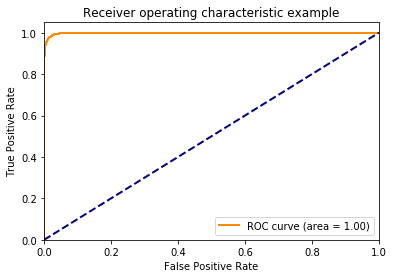

In [39]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

### PR curve

In [40]:
# Compute PR curve and AP for each class
precision = dict()
recall = dict()
average_precision = dict()
precision, recall, _ = precision_recall_curve(1-test_labels, prediction_scores_test[:, 0])
average_precision = average_precision_score(1-test_labels, prediction_scores_test[:, 0])

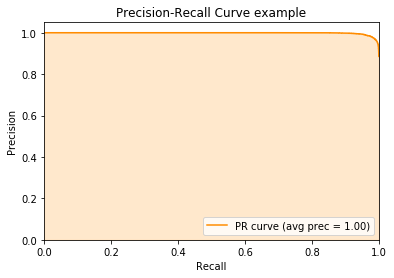

In [41]:
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
#plt.figure(figsize=(10,10))
lw = 2
plt.plot(recall, precision,'-',color='darkorange',label='PR curve (avg prec = %0.2f)' % average_precision)
#plt.step(recall[2], precision[2],color='darkorange',where='post',
#         label='PR curve (avg prec = %0.2f)' % average_precision[2])
plt.fill_between(recall, precision, alpha=0.2, color='darkorange')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
prediction_scores_test[:, 0].shape

In [ ]:
test_labels.shape

### What are the incorrect predictions?

In [19]:
Predictions_train = model.predict_classes(train_images)

In [20]:
indices_incorrect_predictions_in_train = [i for i, x in enumerate(list(Predictions_train == train_labels.reshape(len(train_labels)))) if x == False ]
print("Total Number of Incorrect Predictions among Train data : ", len(indices_incorrect_predictions_in_train))

Total Number of Incorrect Predictions among Train data :  60606


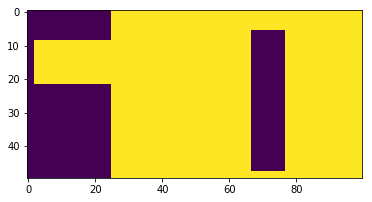

Real Label :  [0]
Predicted Label :  1
Target Criteria :  13
Ligand Criteria :  [42 10]


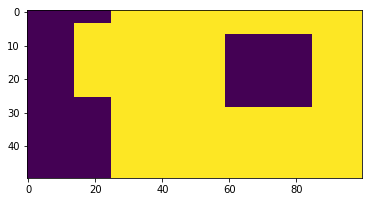

Real Label :  [0]
Predicted Label :  1
Target Criteria :  22
Ligand Criteria :  [22 26]


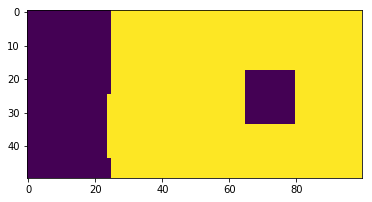

Real Label :  [0]
Predicted Label :  1
Target Criteria :  19
Ligand Criteria :  [16 15]


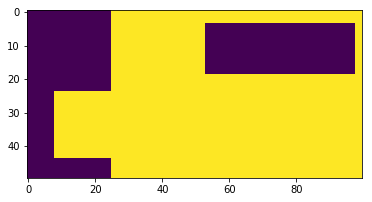

Real Label :  [0]
Predicted Label :  1
Target Criteria :  20
Ligand Criteria :  [15 45]


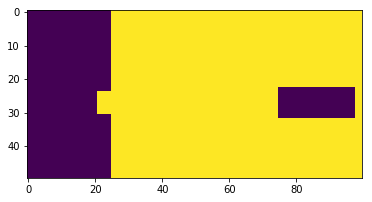

Real Label :  [0]
Predicted Label :  1
Target Criteria :  7
Ligand Criteria :  [ 9 23]


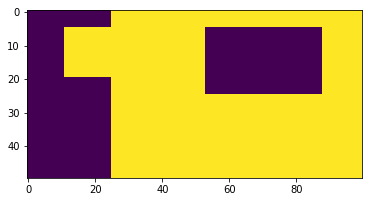

Real Label :  [0]
Predicted Label :  1
Target Criteria :  15
Ligand Criteria :  [20 35]


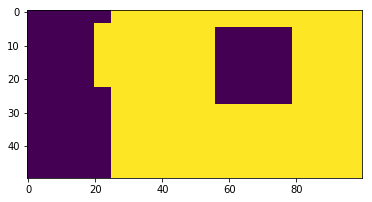

Real Label :  [0]
Predicted Label :  1
Target Criteria :  19
Ligand Criteria :  [23 23]


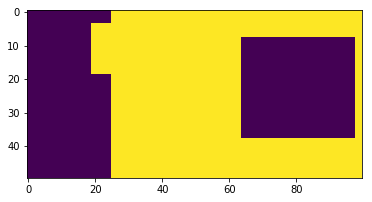

Real Label :  [0]
Predicted Label :  1
Target Criteria :  15
Ligand Criteria :  [30 34]


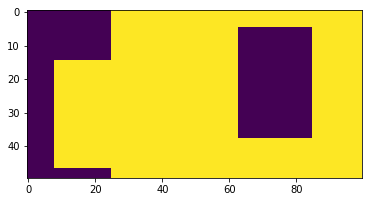

Real Label :  [0]
Predicted Label :  1
Target Criteria :  32
Ligand Criteria :  [33 22]


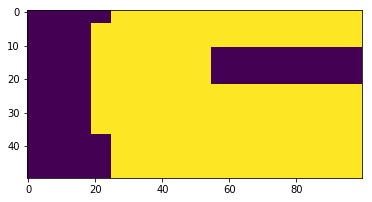

Real Label :  [0]
Predicted Label :  1
Target Criteria :  33
Ligand Criteria :  [11 45]


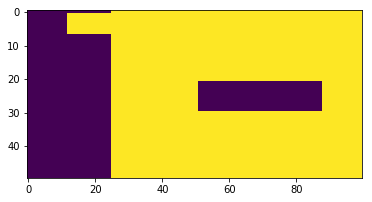

Real Label :  [0]
Predicted Label :  1
Target Criteria :  6
Ligand Criteria :  [ 9 37]


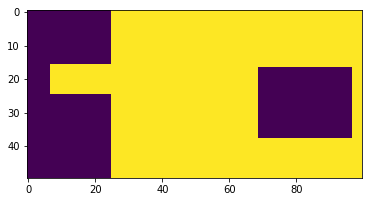

Real Label :  [0]
Predicted Label :  1
Target Criteria :  9
Ligand Criteria :  [21 28]


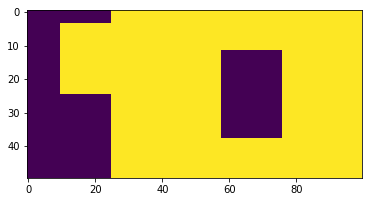

Real Label :  [0]
Predicted Label :  1
Target Criteria :  21
Ligand Criteria :  [26 18]


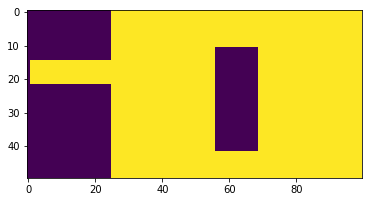

Real Label :  [0]
Predicted Label :  1
Target Criteria :  7
Ligand Criteria :  [31 13]


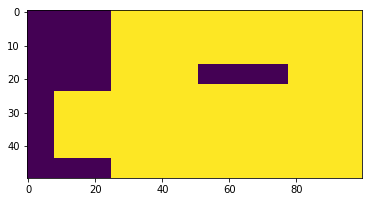

Real Label :  [0]
Predicted Label :  1
Target Criteria :  20
Ligand Criteria :  [ 6 27]


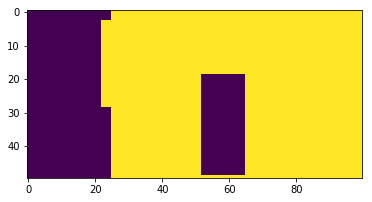

Real Label :  [0]
Predicted Label :  1
Target Criteria :  26
Ligand Criteria :  [30 13]


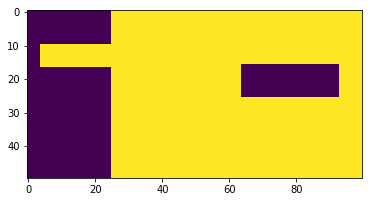

Real Label :  [0]
Predicted Label :  1
Target Criteria :  7
Ligand Criteria :  [10 29]


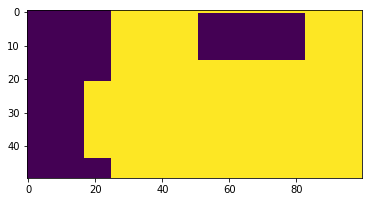

Real Label :  [0]
Predicted Label :  1
Target Criteria :  23
Ligand Criteria :  [14 32]


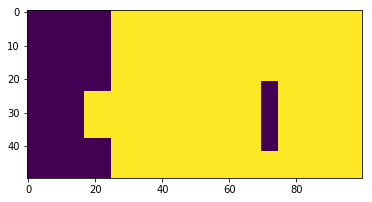

Real Label :  [0]
Predicted Label :  1
Target Criteria :  14
Ligand Criteria :  [21  5]


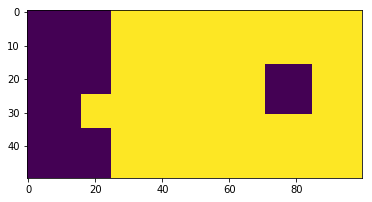

Real Label :  [0]
Predicted Label :  1
Target Criteria :  10
Ligand Criteria :  [15 14]


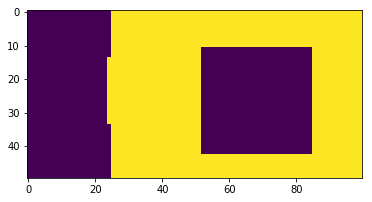

Real Label :  [0]
Predicted Label :  1
Target Criteria :  20
Ligand Criteria :  [32 33]


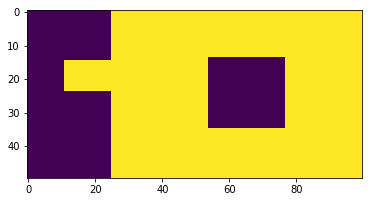

Real Label :  [0]
Predicted Label :  1
Target Criteria :  9
Ligand Criteria :  [21 23]


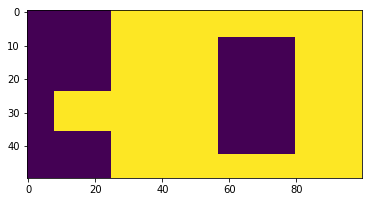

Real Label :  [0]
Predicted Label :  1
Target Criteria :  12
Ligand Criteria :  [35 23]


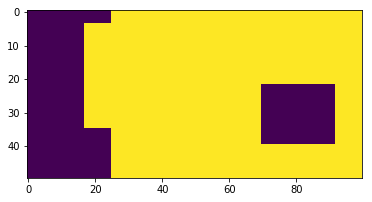

Real Label :  [0]
Predicted Label :  1
Target Criteria :  31
Ligand Criteria :  [18 22]


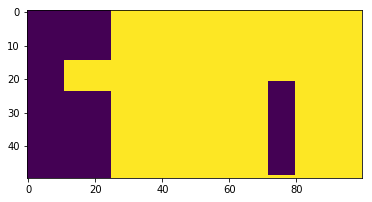

Real Label :  [0]
Predicted Label :  1
Target Criteria :  9
Ligand Criteria :  [28  8]


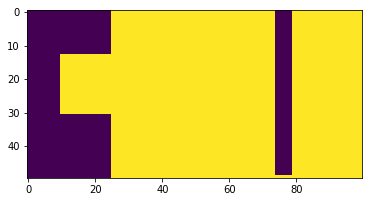

Real Label :  [0]
Predicted Label :  1
Target Criteria :  18
Ligand Criteria :  [49  5]


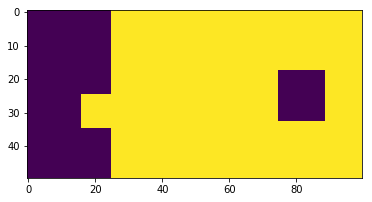

Real Label :  [0]
Predicted Label :  1
Target Criteria :  10
Ligand Criteria :  [15 14]


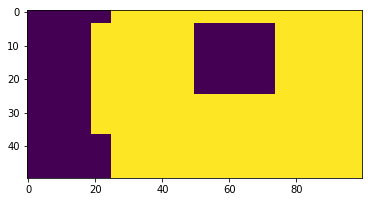

Real Label :  [0]
Predicted Label :  1
Target Criteria :  33
Ligand Criteria :  [21 24]


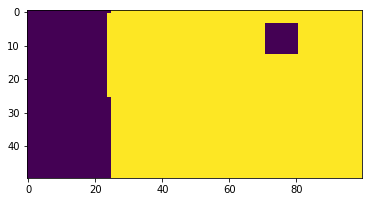

Real Label :  [0]
Predicted Label :  1
Target Criteria :  25
Ligand Criteria :  [ 9 10]


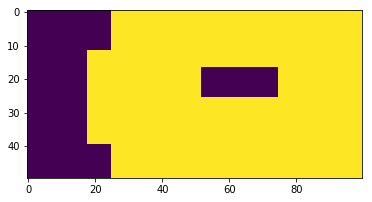

Real Label :  [0]
Predicted Label :  1
Target Criteria :  28
Ligand Criteria :  [ 9 23]


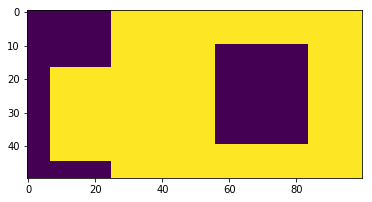

Real Label :  [0]
Predicted Label :  1
Target Criteria :  28
Ligand Criteria :  [30 28]


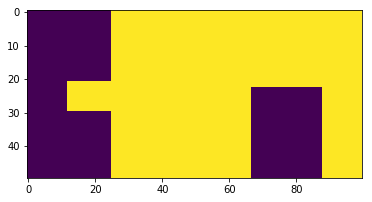

Real Label :  [0]
Predicted Label :  1
Target Criteria :  9
Ligand Criteria :  [27 21]


In [21]:
for k, idx in enumerate(indices_incorrect_predictions_in_train):
    plt.imshow(train_images[idx,:,:,0])
    plt.show()
    print('Real Label : ', train_labels[idx])
    print('Predicted Label : ', Predictions_train[idx])
    print('Target Criteria : ', train_target_criteria[idx])
    print('Ligand Criteria : ', train_ligand_criteria[idx])
    if k > 30:
        break

In [ ]:
Predictions_test = model.predict_classes(test_images)

In [ ]:
indices_incorrect_predictions_in_test = [i for i, x in enumerate(list(Predictions_test == test_labels.reshape(len(test_labels)))) if x == False ]
print("Total Number of Incorrect Predictions among Test data : ", len(indices_incorrect_predictions_in_test))

In [ ]:
for k, idx in enumerate(indices_incorrect_predictions_in_test):
    plt.imshow(test_images[idx,:,:,0])
    plt.show()
    print('Real Label : ', test_labels[idx])
    print('Predicted Label : ', Predictions_test[idx])
    print('Target Criteria : ', test_target_criteria[idx])
    print('Ligand Criteria : ', test_ligand_criteria[idx])
    #if k > 30:
    #    break

In [ ]:
ls = ['a', 'b', 'c']
for i, s in enumerate(ls):
    print(i, s)

In [ ]:
ls[0]

In [ ]:
idx = indices_incorrect_predictions_in_train[0]
plt.imshow(train_images[idx,:,:,0])
print('Real Label : ', train_labels[idx])
print('Predicted Label : ', Predictions_train[idx])

In [ ]:
idx = indices_incorrect_predictions_in_train[1]
plt.imshow(train_images[idx,:,:,0])
print('Real Label : ', train_labels[idx])
print('Predicted Label : ', Predictions_train[idx])

In [ ]:
for _, idx in enumerate(indices_incorrect_predictions_in_train):
    plt.imshow(train_images[idx,:,:,0])
    print('Real Label : ', train_labels[idx])
    print('Predicted Label : ', Predictions_train[idx])

In [ ]:
plt.figure()
plt.imshow(train_images[1,:,:,0])
plt.grid(False)
plt.show()

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i,:,:,0], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

In [ ]:
predictions = model.predict(test_images)

In [ ]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array[i], true_label[i], img[i,:,:,0]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(2), predictions_array, color="#777777")
  plt.ylim([0, 1]) 
  predicted_label = np.argmax(predictions_array)
 
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

In [ ]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions,  test_labels)
plt.show()

In [ ]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions,  test_labels)
plt.show()

In [ ]:
# Plot the first X test images, their predicted label, and the true label
# Color correct predictions in blue, incorrect predictions in red
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions, test_labels)
plt.show()

In [ ]:
img = test_images[0]

print(img.shape)

In [ ]:
img = (np.expand_dims(img,0))

print(img.shape)

In [ ]:
predictions_single = model.predict(img)

print(predictions_single)

In [ ]:
plot_value_array(0, predictions_single, test_labels)
_ = plt.xticks(range(10), class_names, rotation=45)

In [ ]:
np.argmax(predictions_single[0])